## Forecasting techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = "svg"

In [2]:
!curl https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/electricity_consumption/Electric_Production.csv --output Electric_Production.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8008  100  8008    0     0  13549      0 --:--:-- --:--:-- --:--:-- 13549


In [3]:
dataset_path = "Electric_Production.csv"

In [4]:
df = pd.read_csv(dataset_path)
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [5]:
df = df.rename(columns={"DATE": "date", "Value": "value"})
df["date"] = pd.to_datetime(df["date"], format="%m-%d-%Y")
df = df.set_index("date").asfreq("MS")
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [6]:
df.iloc[[0, -1]]

,value
date,
1985-01-01,72.5052
2018-01-01,129.4048


### 1. Naive Approach

In [7]:
train = df[df.index <= "2012-8-1"].copy()
valid = df[df.index > "2012-8-1'"].copy()

In [8]:
y_hat = valid.copy()

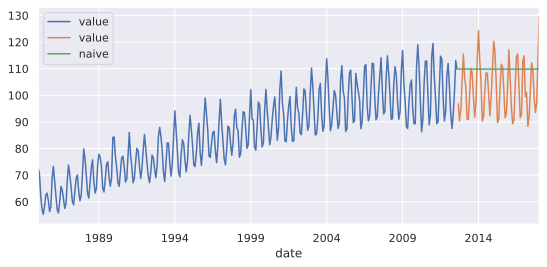

In [9]:
#Copy Last train value
y_hat["naive"] = train["value"].iloc[-1]

fig, ax = plt.subplots(figsize=(9, 4))
train.plot(ax=ax, label="train")
valid.plot(ax=ax, label="val")
y_hat["naive"].plot(ax=ax, label="naive")
ax.legend()
plt.show()

In [10]:
#Calculate RMSE
print("RMSE Naive:", mean_squared_error(y_hat["value"], y_hat["naive"], squared=True))

RMSE Naive: 144.18290826476925


### 2. Moving Average

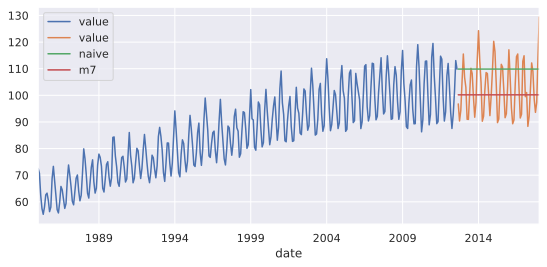

In [11]:
y_hat["m7"] = train["value"].rolling(7).mean().iloc[-1]

fig, ax = plt.subplots(figsize=(9, 4))
train.plot(ax=ax, label="train")
valid.plot(ax=ax, label="val")
y_hat["naive"].plot(ax=ax, label="naive")
y_hat["m7"].plot(ax=ax, label="m7")
ax.legend()
plt.show()

In [12]:
#Calculate RMSE
print("RMSE M7:", mean_squared_error(y_hat["value"], y_hat["m7"], squared=True))

RMSE M7: 101.21254960492308


### 3. Holt's Linear Trend Model

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose as decompose
from statsmodels.tsa.holtwinters import Holt

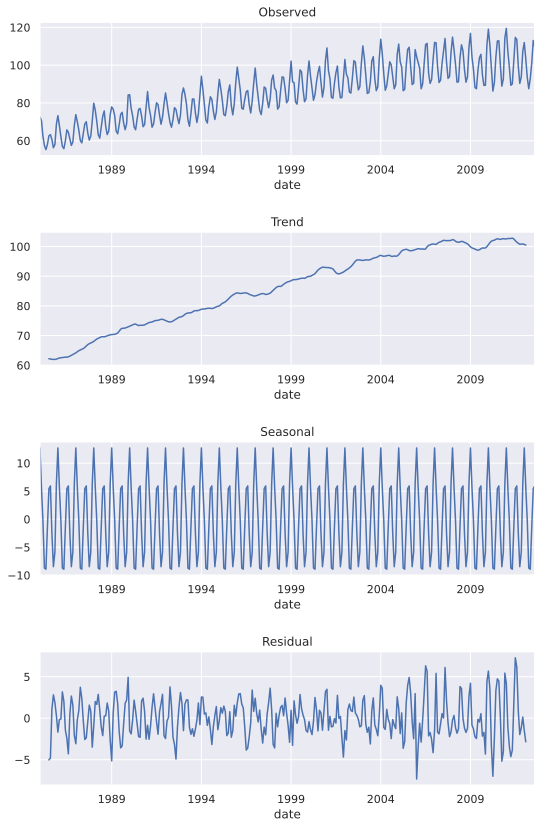

In [14]:
#Save TS decomposed components in a var
result = decompose(train)

fig, ax = plt.subplots(4, 1, figsize=(8, 12))
result.observed.plot(ax=ax[0], title="Observed")
result.trend.plot(ax=ax[1], title="Trend")
result.seasonal.plot(ax=ax[2], title="Seasonal")
result.resid.plot(ax=ax[3], title="Residual")
plt.tight_layout(pad=2)

/home/henrique/Documents/data-science-school/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


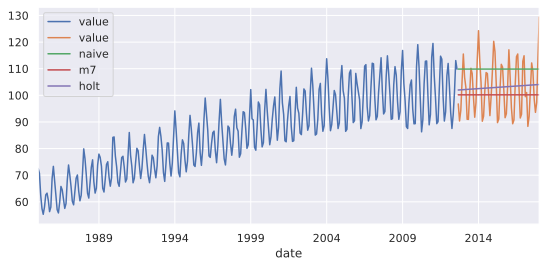

In [15]:
y_hat["holt"] = Holt(train["value"]).fit(smoothing_level=0.1, smoothing_trend=0.1).forecast(len(valid))

fig, ax = plt.subplots(figsize=(9, 4))
train.plot(ax=ax, label="train")
valid.plot(ax=ax, label="val")
y_hat["naive"].plot(ax=ax, label="naive")
y_hat["m7"].plot(ax=ax, label="m7")
y_hat["holt"].plot(ax=ax, label="holt")
ax.legend()
plt.show()

In [16]:
#Calculate RMSE
print("RMSE Holt:", mean_squared_error(y_hat["value"], y_hat["holt"], squared=True))

RMSE Holt: 93.79197449495196


## Stationary Series

1. Constant average over time
2. Constant variance over time
3. Constant covariance between Ti and Ti+m over time

Non-stationary -> depends on time

### Augmented Dickey-Fuller (ADF) Test: Check whether a series is stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
df2 = pd.read_csv(dataset_path, index_col=0, squeeze=True, parse_dates=True).asfreq("MS")

In [19]:
X = df2.to_numpy()

adf_result = adfuller(X)

In [20]:
print("Augmented Dickey-Fuller")
print(f"Statistical Test: {adf_result[0]:.4f}")
print(f"P-Value: {adf_result[1]:.4f}")
print("Critical Values")
for k, v in adf_result[4].items():
    print(f"\t{k}: {v:.4f}")

Augmented Dickey-Fuller
Statistical Test: -2.2570
P-Value: 0.1862
Critical Values
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


H0 --> ts isn't stationary<br>
H1 --> rejects H0 (ts is stationary)

p-value <= 0.05: H1<br>
p-value >= 0.05: H0